In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose

In [2]:
import matplotlib.pyplot as plt

In [3]:
value = tf.random.normal([1, 100])

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [5]:
print(train_images.shape)
print(train_images.dtype)

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

print(train_images.shape)
print(train_images.dtype)

(60000, 28, 28)
uint8
(60000, 28, 28, 1)
float32


In [6]:
train_images = (train_images - 127.5)/127.5  # Normalize images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create Model

In [9]:
def create_generator_model():
    model = Sequential()
    
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100, )))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((7, 7, 256))) # current image size= 7 x 7 x 256
    
    model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))  # current image size= 7 x 7 x 128
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))  # current image size= 14 x 14 x 64
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))  # current image size= 28 x 28 x 1
    
    return model
    

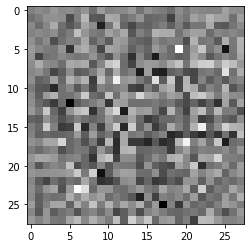

In [12]:
generator = create_generator_model()

noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')